In [49]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import display
from scipy import stats
from yellowbrick.cluster import KElbowVisualizer
from matplotlib.lines import Line2D

np.random.seed(0)

# Data Description and Pre-Processing

## Data Collection

In [4]:
# load datasets
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")

In [5]:
# display data shape
dataset = {
    'Customers': customers,
    'Orders': orders,
    'Order Payments': order_payments
}

for x, y in dataset.items():
    print(f'{x}:', y.shape)

Customers: (99441, 5)
Orders: (99441, 8)
Order Payments: (103886, 5)


In [6]:
# display column names
for x, y in dataset.items():
    print(f'{x}:', f'{list(y.columns)}\n')

Customers: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Orders: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Order Payments: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']



In [7]:
# create master dataframe
df = orders.merge(customers, on='customer_id').merge(order_payments, on='order_id')
display(df.head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,credit_card,3,179.12


## Feature Selection

In [8]:
# rename variables
df.rename(columns={'order_purchase_timestamp':'timestamp'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df.rename(columns={'payment_value':'value'}, inplace=True)

In [9]:
# select relevant variables
df = df[['customer_unique_id', 'order_id', 'timestamp', 'value']]
df.rename(columns={'customer_unique_id':'customer_id'}, inplace=True)
print(df.shape)

(103886, 4)


In [10]:
# display start and end of dataset
print(df['timestamp'].max())
print(df['timestamp'].min())

2018-10-17 17:30:18
2016-09-04 21:15:19


In [11]:
# show an example of a customer's purchase history
display(df[df['customer_id'] == '35ecdf6858edc6427223b64804cf028e'])

,customer_id,order_id,timestamp,value
5839,35ecdf6858edc6427223b64804cf028e,bcb0343717a9e0265e156e34c25c3dc0,2017-08-05 14:55:19,111.54
35747,35ecdf6858edc6427223b64804cf028e,5a4ae77af140c48f0cd65b631bdcb342,2017-08-05 14:55:19,107.48
59241,35ecdf6858edc6427223b64804cf028e,abbfe78fd05873101e792fa04bbad963,2017-10-03 01:25:30,233.28
93733,35ecdf6858edc6427223b64804cf028e,a383762bd79949e1b34878460042cd23,2018-03-31 21:18:49,88.94
103266,35ecdf6858edc6427223b64804cf028e,0095790a64527ec83aeaaf99023c050e,2017-11-15 13:36:30,62.66


## Data Cleaning

In [12]:
# check for null values
print(df.isnull().sum())

customer_id    0
order_id       0
timestamp      0
value          0
dtype: int64


In [13]:
# sort the dataset by customer ID
df.sort_values('customer_id')
display(df.head())

,customer_id,order_id,timestamp,value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,18.12
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2.00
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,18.59
3,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,141.46
4,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,179.12


## Feature Extraction

In [14]:
# create RFM values
last_date = pd.to_datetime('2018-10-18 00:00:00', format='%Y-%m-%d %H:%M:%S')
rfm = df.groupby('customer_id').agg({'timestamp': lambda date: (last_date - date.max()).days,
                                    'order_id': lambda num: num.nunique(),
                                    'value': lambda total: total.sum()}).reset_index()
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
display(rfm.head())

,customer_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,586,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89


# Descriptive Statistics and Data Visualisation

In [15]:
# descriptive statistics of RFM values
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,96095.0,288.103876,153.411046,0.0,164.00,269.0,397.00,773.00
frequency,96095.0,1.034809,0.214385,1.0,1.00,1.0,1.00,17.00
monetary,96095.0,166.594226,231.428912,0.0,63.12,108.0,183.53,13664.08


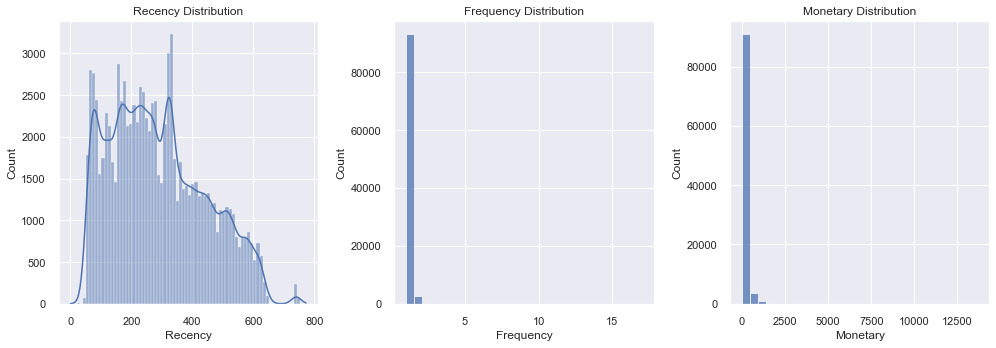

In [16]:
# histograms of RFM values
sns.set()

cols = ['recency', 'frequency', 'monetary']

fig, axes = plt.subplots(1, 3, figsize=(14,5))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    if (col == 'recency'):
        sns.histplot(data=rfm[col], kde=True, ax=ax).set(title=f'{col.capitalize()} Distribution', xlabel=f'{col.capitalize()}')
    else:
        sns.histplot(data=rfm[col], ax=ax, bins=30).set(title=f'{col.capitalize()} Distribution', xlabel=f'{col.capitalize()}')

fig.tight_layout()
plt.show()

In [17]:
# identify the skewness of each variable using a skewtest
for col in rfm.columns[1:]:
    skew = stats.skew(rfm[col])
    print(f'{col.capitalize()}: {skew}')

Recency: 0.4452987438055925
Frequency: 11.862346246727308
Monetary: 9.46704439277844


In [18]:
# percentage of customers making only one purchase
print(len(rfm[rfm['frequency'] == 1])/len(rfm))

0.9688121130131641


In [19]:
# identify top-spending customers
top_spenders = rfm[['customer_id', 'monetary']].sort_values('monetary', ascending=False)
top_spenders.rename(columns={'monetary':'total_spend'}, inplace=True)
top_spenders['%total'] = (top_spenders['total_spend'] / top_spenders['total_spend'].sum()) * 100
top_spenders['cum_%total'] = top_spenders['%total'].cumsum()
display(top_spenders.head())

,customer_id,total_spend,%total,cum_%total
3826,0a0a92112bd4c708ca5fde585afaa872,13664.08,0.085353,0.085353
26456,46450c74a0d8c5ca9395da1daac6c120,9553.02,0.059673,0.145026
81961,da122df9eeddfedc1dc1f5349a1a690c,7571.63,0.047296,0.192323
44447,763c8b1c9c68a0229c42c9fc6f662b93,7274.88,0.045443,0.237766
82807,dc4802a71eae9be1dd28f5d788ceb526,6929.31,0.043284,0.281050


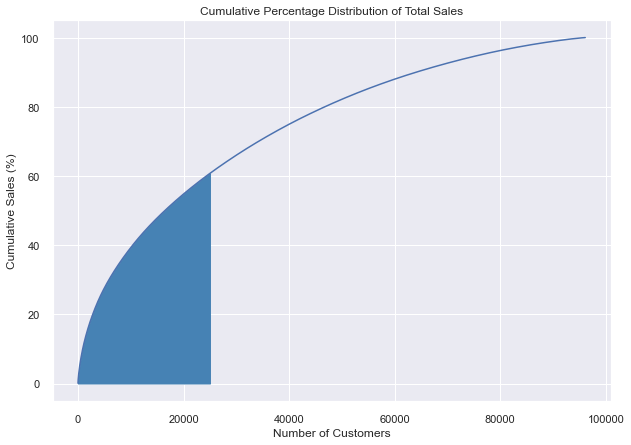

In [20]:
# plot customers' sales contributions
plt.figure(figsize=(10,7))
sns.lineplot(x=range(1,len(top_spenders)+1), y=top_spenders['cum_%total']).set(
            title='Cumulative Percentage Distribution of Total Sales', xlabel='Number of Customers',
            ylabel='Cumulative Sales (%)')
a = np.arange(1,len(top_spenders)+1)
b = top_spenders['cum_%total']
plt.fill_between(a, b, where = (a >= 0) & (a <= 25000), color='steelblue')
plt.show()

# Model development and description

In [21]:
# remove zeros and perform a log transformation on F and M as they are highly skewed
rfm[rfm.columns[1:]] = rfm[rfm.columns[1:]].applymap(lambda x: 1 if x == 0 else x)
rfm_log = rfm.copy()
rfm_log['frequency'] = np.log10(rfm_log['frequency'])
rfm_log['monetary'] = np.log10(rfm_log['monetary'])
rfm_log.head()

,customer_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,0.0,2.151982
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,0.0,1.434409
2,0000f46a3911fa3c0805444483337064,586,0.0,1.935608
3,0000f6ccb0745a6a4b88665a16c9f078,370,0.0,1.639686
4,0004aac84e0df4da2b147fca70cf8255,337,0.0,2.294224


In [22]:
# normalise RFM variables to make them comparable
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(rfm_log.copy().drop('customer_id', axis=1))
rfm_scaled = pd.DataFrame(x_scaled, columns=rfm_log.columns[1:])
rfm_scaled.head()

,recency,frequency,monetary
0,0.205959,0.0,0.520358
1,0.209845,0.0,0.346846
2,0.757772,0.0,0.468038
3,0.477979,0.0,0.396483
4,0.435233,0.0,0.554753


In [23]:
rfm_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,96095.0,0.371896,0.198719,0.0,0.211140,0.34715,0.512953,1.0
frequency,96095.0,0.008087,0.046043,0.0,0.000000,0.00000,0.000000,1.0
monetary,96095.0,0.495799,0.086104,0.0,0.435288,0.49169,0.547373,1.0


# K-Means Clustering & Silhouette Analysis

For k = 2, the average silhouette score is: 0.47278169252273283
For k = 3, the average silhouette score is: 0.39061752628116264
For k = 4, the average silhouette score is: 0.31609344053719457
For k = 5, the average silhouette score is: 0.3229173807040912
For k = 6, the average silhouette score is: 0.31492696895222005


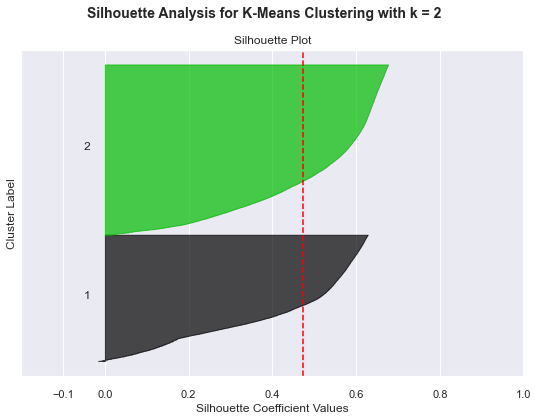

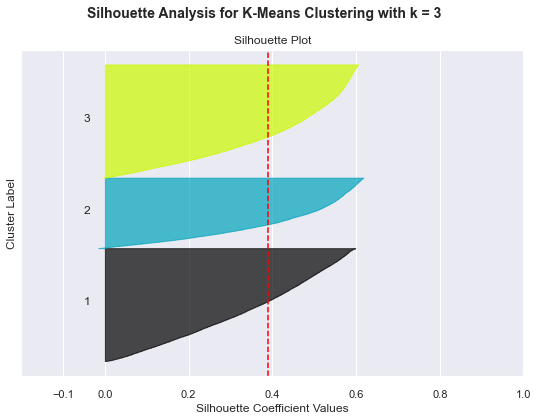

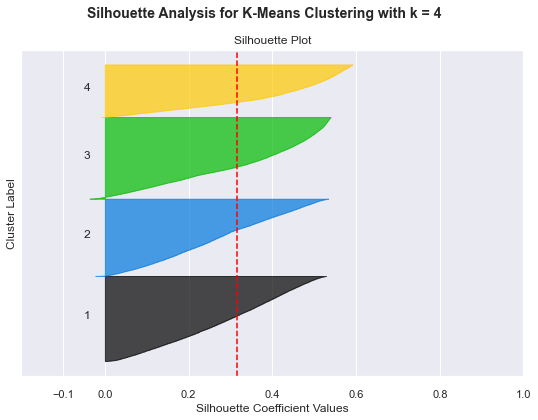

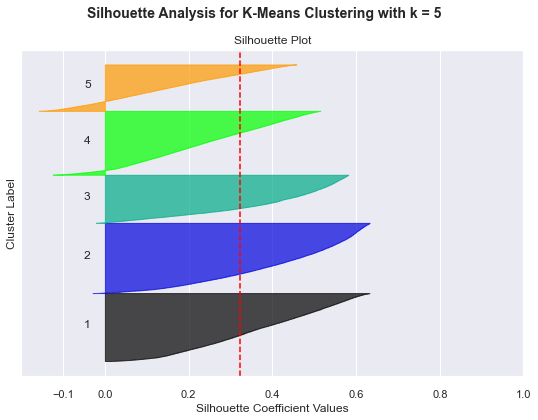

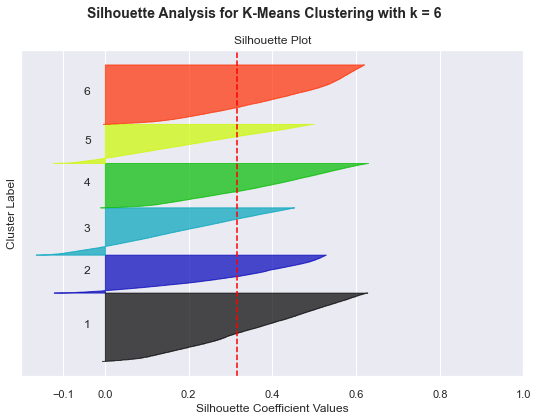

In [24]:
# select the number of clusters with silhouette analysis
k_range = range(2, 7)
for k in k_range:
    fig, ax = plt.subplots(1, 1, figsize=(9,6))
    ax.set_xlim([-0.2, 1])
    
    clusterer = KMeans(n_clusters=k, random_state=42)
    cluster_labels = clusterer.fit_predict(rfm_scaled)
    
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print(f'For k = {k}, the average silhouette score is: {silhouette_avg}')
    
    sample_silhouette_values = silhouette_samples(rfm_scaled, cluster_labels)
    y_lower = 10
    
    for i in range(k):
        i_silhouette_values = sample_silhouette_values[cluster_labels == i]
        i_silhouette_values.sort()
        
        i_size = i_silhouette_values.shape[0]
        y_upper = y_lower + i_size
        
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, i_silhouette_values, facecolor=color, 
                         edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * i_size, str(i+1))
        y_lower = y_upper + 10
    
    ax.set_title('Silhouette Plot')
    ax.set_xlabel('Silhouette Coefficient Values')
    ax.set_ylabel('Cluster Label')
    ax.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(f'Silhouette Analysis for K-Means Clustering with k = {k}', fontsize=14, fontweight='bold')

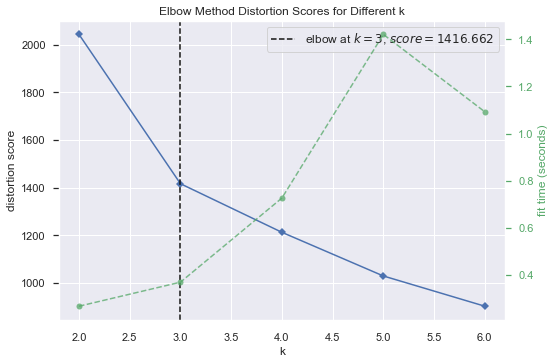

<AxesSubplot:title={'center':'Elbow Method Distortion Scores for Different k'}, xlabel='k', ylabel='distortion score'>

In [41]:
# Confirm the optimal k selection with the elbow method
visualizer = KElbowVisualizer(KMeans(), k=(2,7), title='Elbow Method Distortion Scores for Different k')
visualizer.fit(rfm_scaled)
visualizer.ax.set_ylabel('Distortion Score')
visualizer.show()

In [30]:
# train the model on 3 clusters and add them to the dataframe
clusterer = KMeans(n_clusters=3, random_state=42)
cluster_labels = clusterer.fit_predict(rfm_scaled)
rfm['cluster'] = clusterer.labels_ + 1

In [48]:
# show average RFM values for the clusters
rfm_clusters = rfm.groupby(['cluster']).agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'})
rfm_clusters['count'] = rfm.groupby(['cluster'])['cluster'].count()
rfm_clusters['percentage'] = rfm.groupby(['cluster'])['cluster'].count() / len(rfm.index)
rfm_clusters['percentage sales'] = rfm.groupby(['cluster'])['monetary'].sum() / rfm['monetary'].sum()
display(rfm_clusters)

,recency,frequency,monetary,count,percentage,percentage sales
cluster,,,,,,
1,303.719998,1.034597,161.222655,36564,0.380498,0.368230
2,507.756346,1.027311,166.276338,22848,0.237765,0.237311
3,135.727939,1.039691,172.146422,36683,0.381737,0.394459


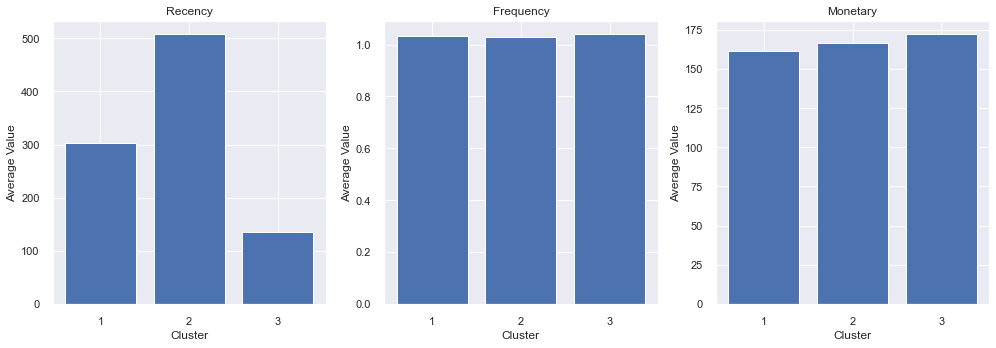

In [32]:
# visualise clusters by RFM values
fig, axes = plt.subplots(1, 3, figsize=(14,5))

axes[0].bar(rfm_clusters.reset_index()['cluster'], rfm_clusters['recency'])
axes[0].set_xticks([1,2,3])
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Average Value')
axes[0].set_title('Recency')

axes[1].bar(rfm_clusters.reset_index()['cluster'], rfm_clusters['frequency'])
axes[1].set_xticks([1,2,3])
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Average Value')
axes[1].set_title('Frequency')

axes[2].bar(rfm_clusters.reset_index()['cluster'], rfm_clusters['monetary'])
axes[2].set_xticks([1,2,3])
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Average Value')
axes[2].set_title('Monetary')

fig.tight_layout()
plt.show()

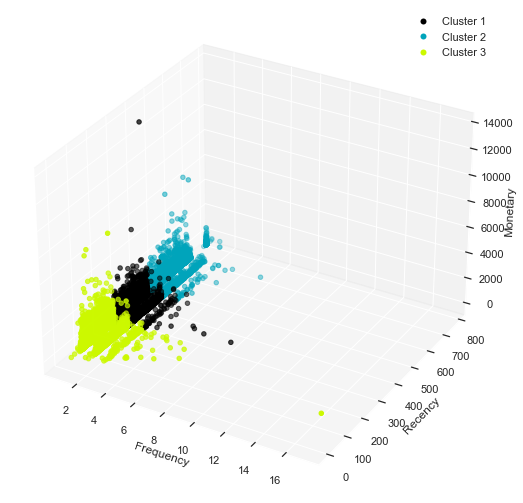

In [64]:
# 3D plot clusters by RFM values
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(projection='3d')

x = rfm['frequency']
y = rfm['recency']
z = rfm['monetary']

rfm['colour'] = (rfm['cluster'].astype(float) - 1) / 3

ax.scatter(x, y, z, c=cm.nipy_spectral(rfm['colour']))
ax.set_facecolor('white')
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster 1',
                         markerfacecolor=cm.nipy_spectral(0.0)),
                   Line2D([0], [0], marker='o', color='w', label='Cluster 2',
                         markerfacecolor=cm.nipy_spectral(1.0/3)),
                   Line2D([0], [0], marker='o', color='w', label='Cluster 3',
                         markerfacecolor=cm.nipy_spectral(2.0/3))]
ax.legend(handles=legend_elements, loc='best')

plt.show()